In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

#from keras.applications import *


from sklearn.model_selection import train_test_split


import bz2
import pickle
import _pickle as cPickle


import matplotlib.pyplot as plt


## Carregamento de dados

In [2]:
# define função para descomprimir arquivo
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [3]:
# connexão com google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# carrega e descomprime dados
with open('./drive/MyDrive/TCC/features.pbz2', 'rb') as file:
  X = decompress_pickle(file)

with open('./drive/MyDrive/TCC/labels.pbz2', 'rb') as file:
  Y = decompress_pickle(file)

## Pré-processamento

In [5]:
X = tf.keras.preprocessing.image.smart_resize(
    X, (224,224), interpolation='bilinear'
)

In [6]:
X = X.astype('float32') / 255.0

In [7]:
# divide dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [8]:
# # divide dataset em treino e teste
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.25, random_state=42)

In [9]:
# # cria objeto para aumentação de dados
# data_generator = ImageDataGenerator(
#       zoom_range=0.2,
#       horizontal_flip=True,
#       validation_split =.25
#       )

In [10]:
# cria gerador de imagens para treino e validação
# train_generator = data_generator.flow(X_train, y_train, subset='training', shuffle=True)
# val_generator = data_generator.flow(X_train, y_train, subset='validation', shuffle=True)

In [11]:
# images, labels = next(train_generator)

# # print the shape of the images array
# print(images.shape)

In [12]:
def create_model(name, backbone, input_shape, preprocess, dropout, optimizer, loss ):

  # Declara o modelo pré-treinado a ser usado   
  base_model = backbone(
      weights="imagenet",
      input_shape=input_shape,
      include_top=False
  )

  # Tornamos o modelo base não treinável, "congelando" os parâmetros
  base_model.trainable = False


  # Nosso modelo como anteriormente
  inputs = keras.Input(shape=input_shape)
  #x = data_augmentation(inputs) 

  inputs = preprocess(
     inputs, data_format=None)

  # Incluindo a MobileNetV2 com parametros pré-treinados, mas ainda não treinável
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = keras.layers.Dense(160,activation="relu", name="projection")(x)
  x = keras.layers.Dropout(dropout)(x) #0.3
  outputs = keras.layers.Dense(1,activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)

  model._name = name
  model.get_layer(index=1)._name = 'backbone'

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy", "Recall", "Precision"]
  )

  return model 

In [18]:
def fine_tune(model, trainable_layers):
  backbone = model.get_layer('backbone')
  # descongela o modelo utilizado como base
  backbone.trainable = True
  # seleciona quais camadas serão treinadas
  for layer in backbone.layers[:- trainable_layers]:
      layer.trainable = False
      # congela tambem camadas de BN
      if isinstance(layer, keras.layers.BatchNormalization):
          layer._per_input_updates = {}

  model.compile(
    optimizer=keras.optimizers.Adam(10e-7), 
    loss="squared_hinge",
    metrics=["accuracy", "Recall", "Precision"],
  )
  
  return model

In [19]:
# model.fit(train_generator, epochs=10,  validation_data=val_generator)

In [20]:

models = {'MobileNet': 
          {'backbone': tf.keras.applications.MobileNetV2,
          'preprocess': tf.keras.applications.mobilenet_v2.preprocess_input
           },
          
          'VGG16' : 
          {'backbone': tf.keras.applications.VGG16,
          'preprocess': tf.keras.applications.vgg16.preprocess_input 
          }, 
          
          'Xception' : 
          {'backbone' : tf.keras.applications.Xception,
          'preprocess' : tf.keras.applications.xception.preprocess_input
          }, 
          
          'ResNet' : 
          {'backbone' : tf.keras.applications.ResNet50,
          'preprocess' : tf.keras.applications.resnet.preprocess_input 
          },
          
          'InceptionResNetV2': 
          {'backbone' : tf.keras.applications.InceptionResNetV2,
          'preprocess': tf.keras.applications.inception_resnet_v2.preprocess_input
          },
          
          'DenseNet121' : 
          {'backbone': tf.keras.applications.DenseNet121,
          'preprocess' : tf.keras.applications.densenet.preprocess_input 
          },
          
          # 'EfficientNetB2' : 
          # {'backbone' : tf.keras.applications.EfficientNetB2,
          # 'preprocess': tf.keras.applications.efficientnet.preprocess_input
          # }
}                             

In [21]:
DRIVE_PATH = './drive/MyDrive/TCC/models'

In [32]:
for key, value in models.items():
  print(f'initizalizing {key.upper()} model')
  model = create_model(
      name=key,
      backbone=models[key]['backbone'],
      preprocess=models[key]['preprocess'],
      input_shape = (224,224,3),
      dropout=0.3,
      optimizer=keras.optimizers.Adam(0.0001),
      loss='squared_hinge'
    )
  model_hist = model.fit(X_train, y_train, epochs=15,validation_split=0.25)

  #model.save(f'{DRIVE_PATH}/{key}_model')

  #tf.saved_model.save(model, f'{DRIVE_PATH}/{key}_model')

  with open(f'{DRIVE_PATH}/{key}_history.pkl', 'wb') as file:
    pickle.dump(model_hist.history, file)

  ## FINE TUNNING 
  
  #model = keras.models.load_model(f'{DRIVE_PATH}/{key}_model')
  model_tuned = fine_tune(model, 5)
    
  model_tuned_hist = model_tuned.fit(
      X_train,
      y_train,
      epochs=5,
      validation_split=0.25
      )

  #model_tuned_hist.save(f'{DRIVE_PATH}/{key}_tuned_model')

  with open(f'{DRIVE_PATH}/{key}_tuned_history.pkl', 'wb') as file:
    pickle.dump(model_tuned_hist.history, file)

initizalizing MOBILENET model
Epoch 1/15
102/102 [==============================] - 8s 37ms/step - loss: 1.0135 - accuracy: 0.5326 - recall: 0.0033 - precision: 0.2632 - val_loss: 1.0013 - val_accuracy: 0.5348 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/15
102/102 [==============================] - 2s 21ms/step - loss: 1.0007 - accuracy: 0.5354 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.0006 - val_accuracy: 0.5348 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/15
102/102 [==============================] - 2s 21ms/step - loss: 1.0003 - accuracy: 0.5354 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.0004 - val_accuracy: 0.5348 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/15
102/102 [==============================] - 2s 22ms/step - loss: 1.0003 - accuracy: 0.5354 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.0002 - val_accuracy: 0.5348 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/15
102

In [33]:
DRIVE_PATH = './drive/MyDrive/TCC/models'

In [34]:
def retrieve_hist(modelo, history_type):
  with open(f'{DRIVE_PATH}/{key}_{history_type}.pkl', 'rb') as file:
    hist = pickle.load(file)
    
  models[key][history_type] = hist 

In [35]:
for key,value in models.items():
  retrieve_hist(key, 'history')

In [36]:
for key,value in models.items():
  retrieve_hist(key, 'tuned_history')

In [37]:
metrics = ['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision']

In [38]:
def plot_metrics(models, metrics, history_name):
  for metric in metrics:
    plt.figure(figsize=(15,6))

    for key in models.keys():
      plt.plot(models[key][history_name][metric])
      
    plt.legend([f'{key}' for key in models.keys() ], loc="upper left")

    plt.title(f'{metric.upper()}');

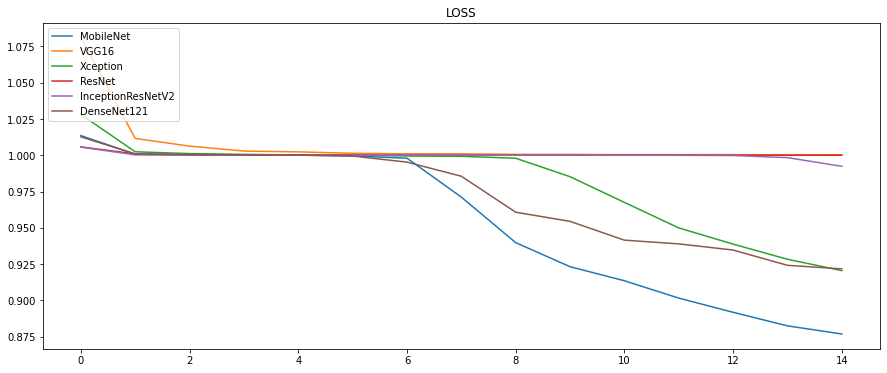

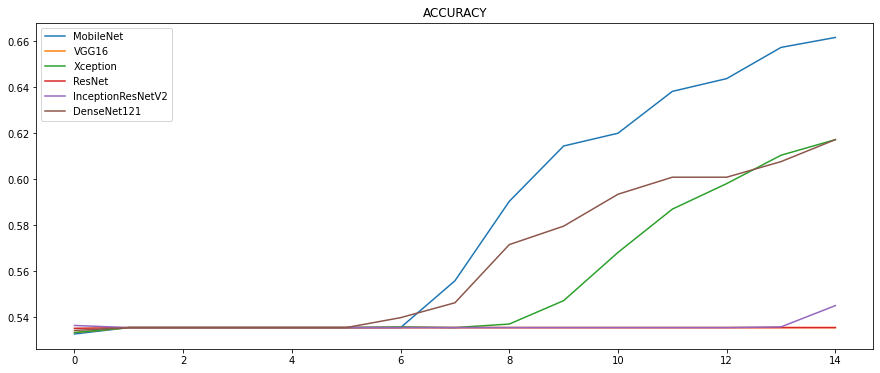

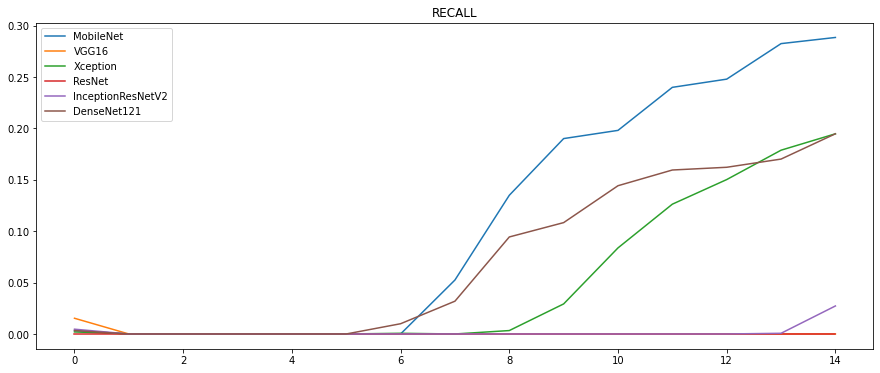

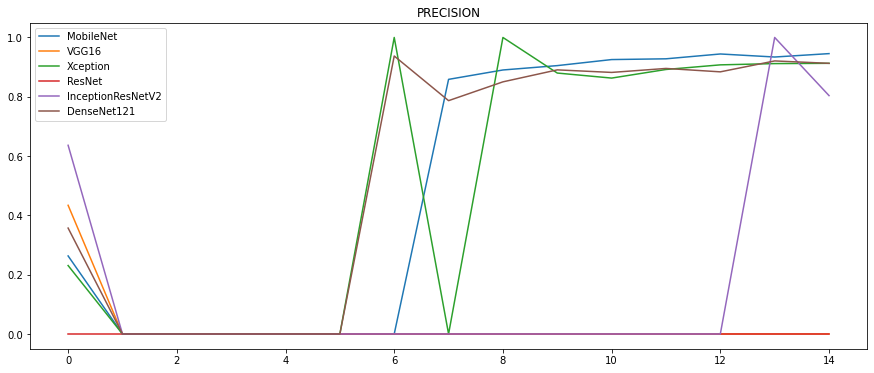

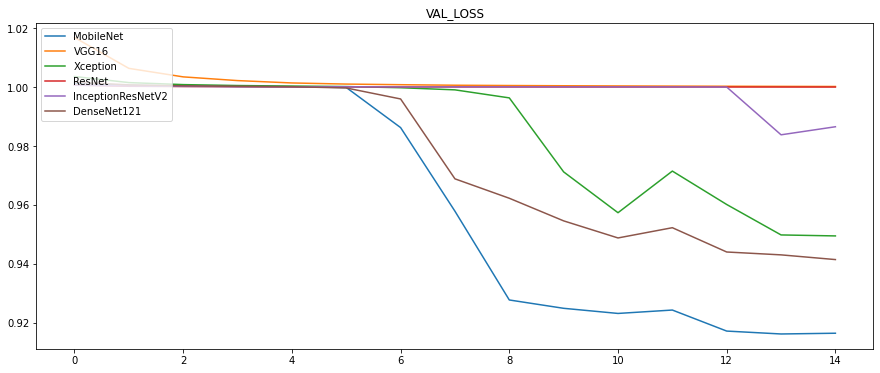

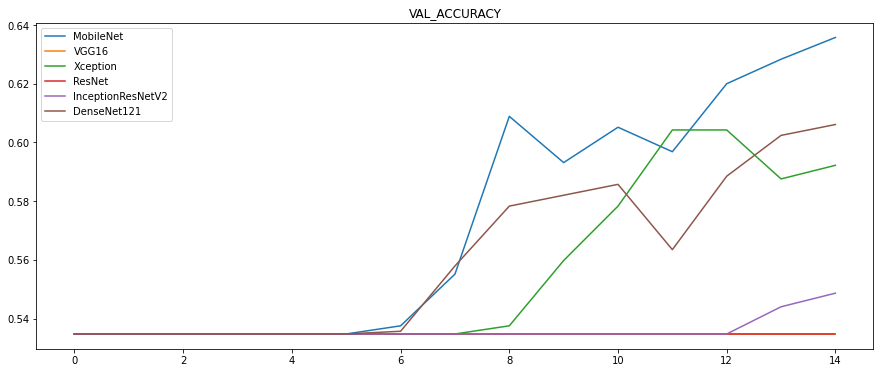

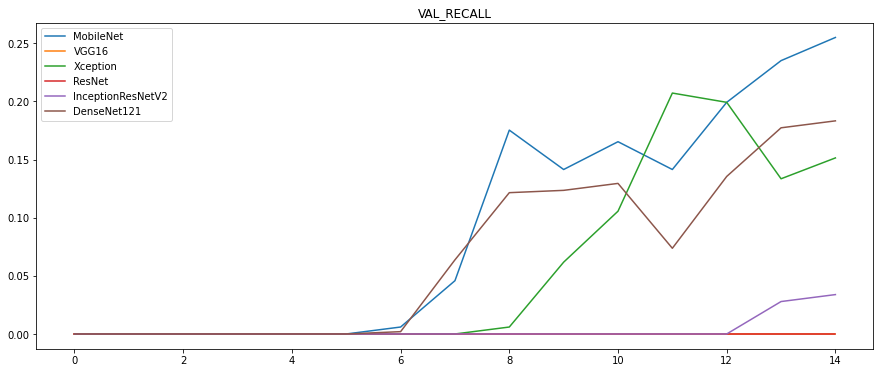

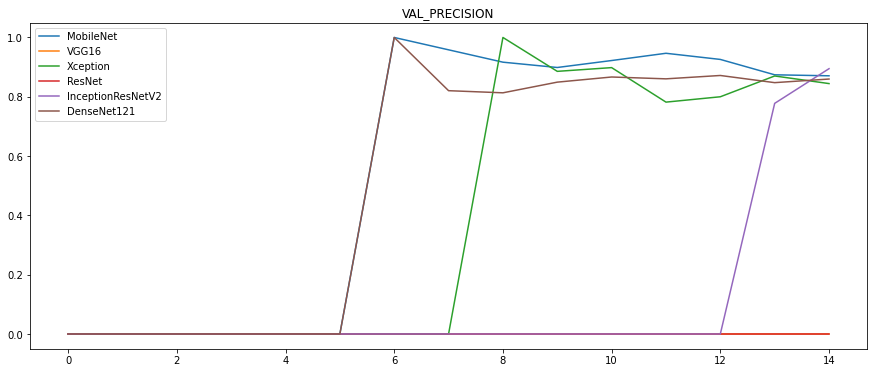

In [39]:
plot_metrics(models=models, metrics=metrics, history_name='history')

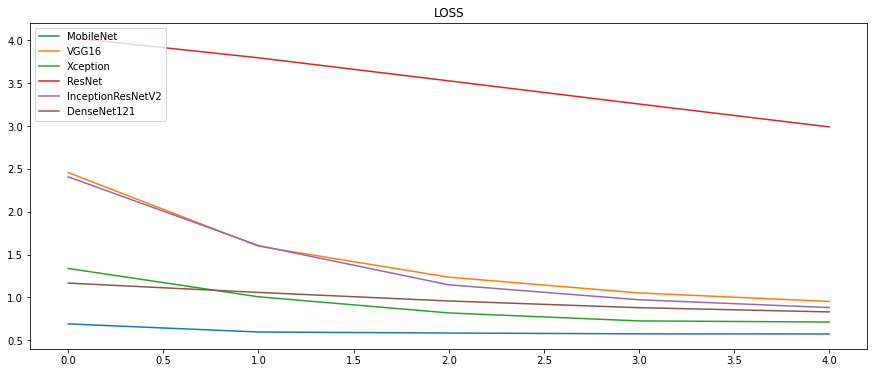

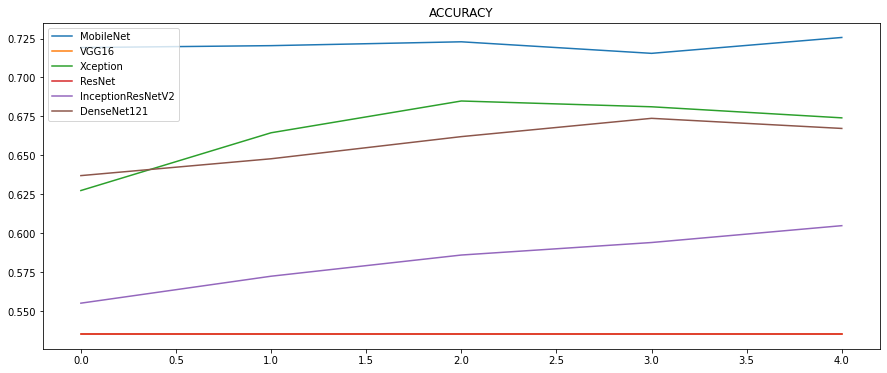

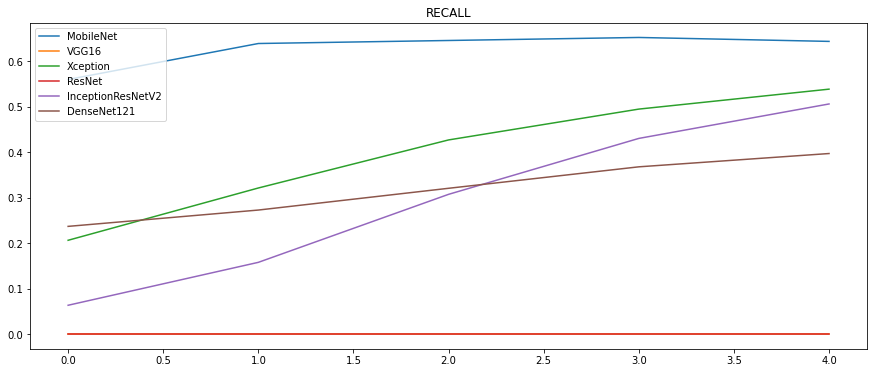

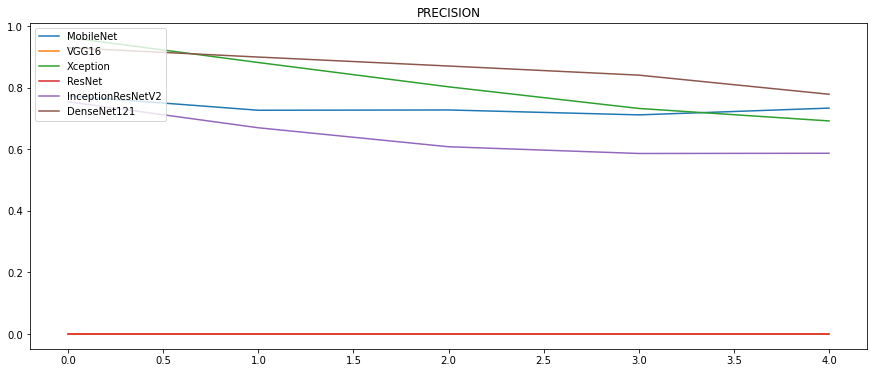

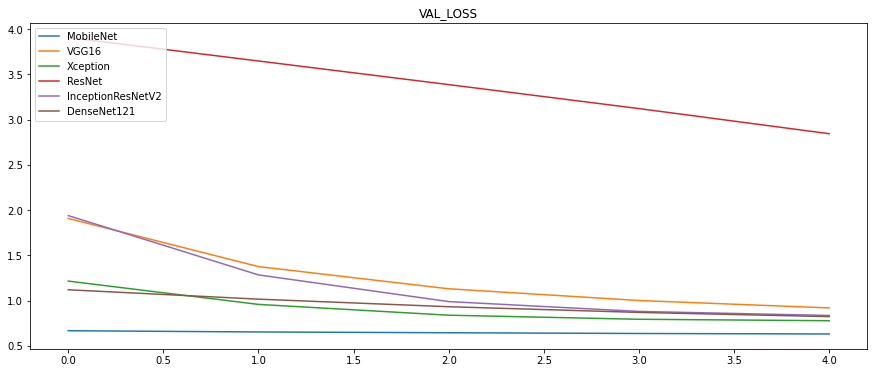

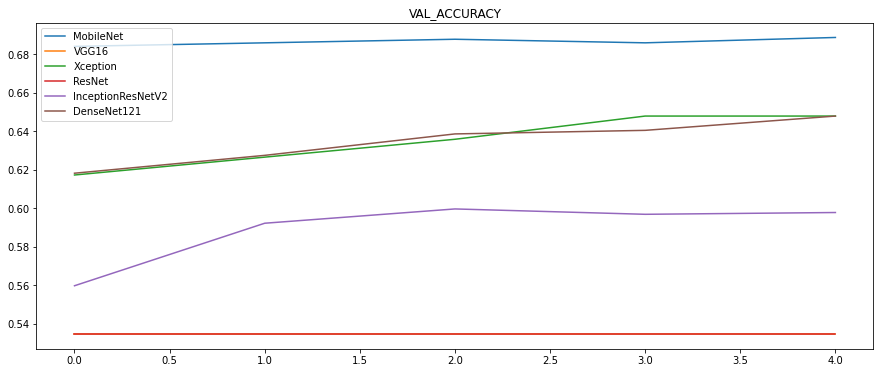

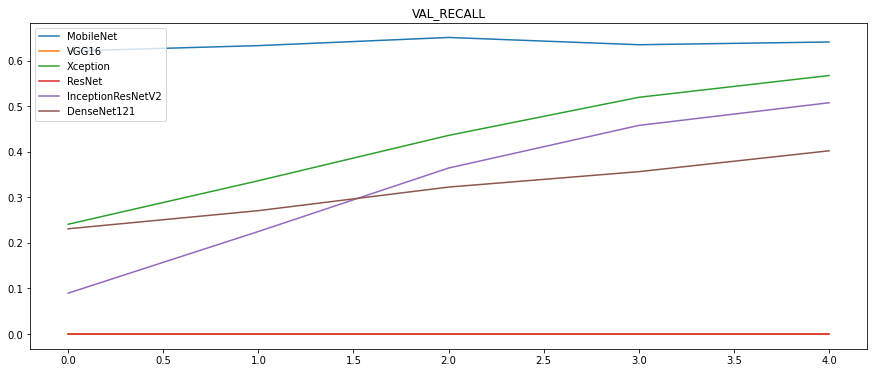

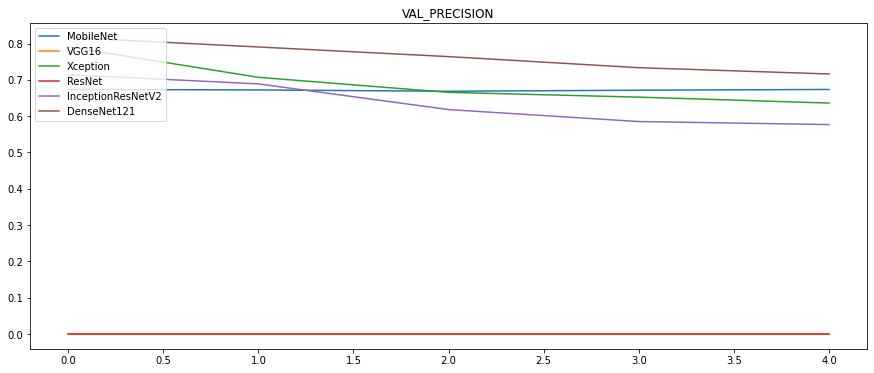

In [40]:
plot_metrics(models=models, metrics=metrics, history_name='tuned_history')

In [26]:
# def fine_tune(model, trainable_layers):
#   backbone = model.get_layer('backbone')
#   # descongela o modelo utilizado como base
#   backbone.trainable = True
#   # seleciona quais camadas serão treinadas
#   for layer in backbone.layers[:- trainable_layers]:
#       layer.trainable = False
#       # congela tambem camadas de BN
#       if isinstance(layer, keras.layers.BatchNormalization):
#           layer._per_input_updates = {}

#   model.compile(
#     optimizer=keras.optimizers.Adam(10e-7), 
#     loss="binary_crossentropy",
#     metrics=["accuracy", "Recall", "Precision"],
#   )
  
#   return model

In [ ]:
# for key, value in models.items():
#   print(f'initizalizing {key.upper()} model')

#   model = keras.models.load_model(f'{DRIVE_PATH}/{key}_model')
#   model_tuned = fine_tune(model, 5)
    
#   model_tuned_hist = model_tuned.fit(
#       X_train,
#       y_train,
#       epochs=5,
#       validation_split=0.25
#       )

#   model_tuned_hist.save(f'{DRIVE_PATH}/{key}_tuned_model')

#   with open(f'{DRIVE_PATH}/{key}_tuned_history.pkl', 'wb') as file:
#     pickle.dump(model_tuned_hist.history, file)

In [ ]:
# for key,value in models.items():
#   retrieve_hist(key, 'tuned_history')

In [ ]:
#plot_metrics()